In [2]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


# Let's start by creating the blackjack environment.

env = gym.make('Blackjack-v1', natural=False, sab=False)
# Whether to follow the exact rules outlined in the book by Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.

We call env.reset() to start an episode. This function resets the environment to a starting position and returns an initial observation. We usually also set done = False. This variable will be useful later to check if a game is terminated (i.e., the player wins or loses).

In [5]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

# observation = (16, 9, False)
    # Note that our observation is a 3-tuple consisting of 3 values:
    # The players current sum
    # Value of the dealers face-up card
    # Boolean whether the player holds a usable ace (An ace is usable if it counts as 11 without busting)

env.step(action) function to interact with the environment. This function takes an action as input and executes it in the environment

In [4]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

Building an Agent 
Using Q-Learning algorithm 
epsilon-greedy strategy:: (randome action: epsilon, the best action 1: greedy)

In [6]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,           # This parameter controls how much the agent's knowledge is updated during training. A higher learning rate means the agent learns faster but could overshoot, while a lower rate means the agent learns more slowly but steadily.
        initial_epsilon: float,         # Is the initial probability of choosing a random action over the best-known action, promoting exploration of the state space.
        epsilon_decay: float,           # This agent learns more about the environment, it will rely more on its learned strategy and less on random exploration.
        final_epsilon: float,           # This ensures that there's always some chance of random exploration, preventing the agent from getting stuck in a suboptimal policy.
        discount_factor: float = 0.95,  # A factor of 0.95 indicates that future rewards are valued at 95% of the immediate rewards, which is quite common in discounting future rewards to prioritize more immediate rewards in the agent's decision-making.
    ):
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n)) #This means that each action's Q-value is initially assumed to be zero until the agent learns otherwise through experience.

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

        

In [7]:
# hyperparameters
learning_rate = 0.01
n_episodes = 3
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [8]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 3/3 [00:00<00:00, 113.20it/s]


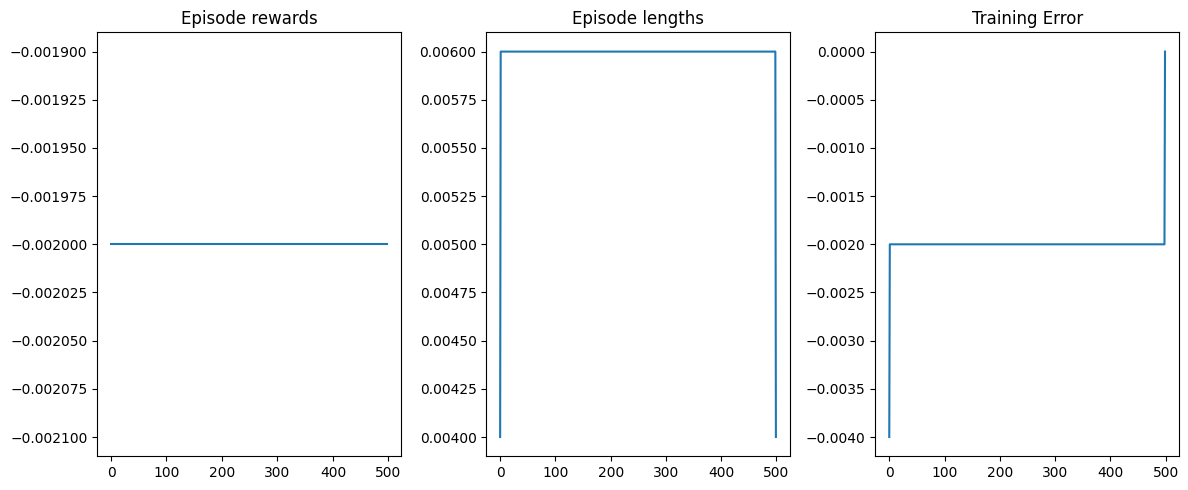

In [9]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()